In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs 
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import cmocean as cmo
plt.rcParams['font.size'] = 14

In [9]:
#slicing and mean
# location of input data
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")
u_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_U.nc"#1/5° without "1_" prefix
v_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_V.nc"
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"

t = xr.open_dataset(data_path / t_file)
u = xr.open_dataset(data_path / u_file)
v = xr.open_dataset(data_path / v_file)

t_lat = t.coords["nav_lat"].values[1:,0]
t_lon = t.coords["nav_lon"].values[0,:]

v_lat = v.coords["nav_lat"].values[1:,0]
u_lon = u.coords["nav_lon"].values[0,:]


#select t array for plots
lat_b = (20,30)
lon_b = (-20,-10)

yt_ind = np.where((t_lat <= lat_b[1]) & (t_lat>= lat_b[0]))[0]  
xt_ind = np.where((t_lon <= lon_b[1]) & (t_lon >= lon_b[0]))[0]

t_sel = t.vosaline[:,:,yt_ind,xt_ind].sel( # 5 oberste schichten
    time_counter = "2011-01-01") # 1 month december
#del t,u,v

In [11]:
#load release zone
exterior = pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_exterior500.csv")).values.tolist()
interior = pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_interior.csv")).values.tolist()

box_poly = Polygon(exterior, [interior])

In [32]:
#shift from cell center to cell edges for pcolormesh plot funtion
cell_shift_x = np.ediff1d(t_lon[xt_ind])[0] / 2  
cell_shift_y = np.ediff1d(t_lat[yt_ind])[0] / 2
# load GSHHS Feature
land = cpf.GSHHSFeature( edgecolor='00', facecolor= None)

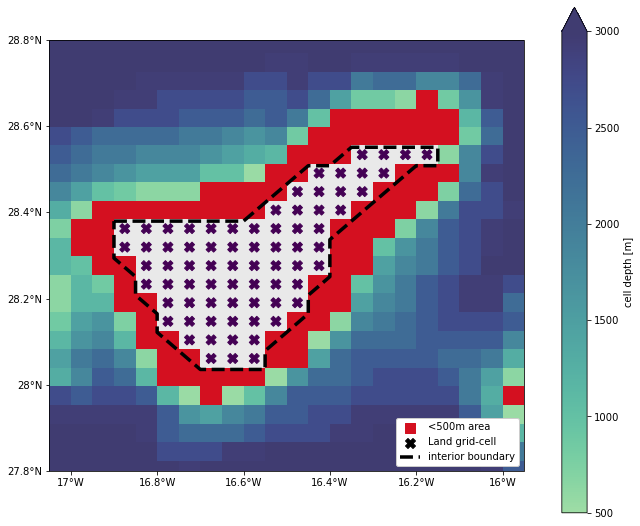

In [36]:
layer_ind = 0
depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int')
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[xt_ind] - cell_shift_x,t_lat[yt_ind] + cell_shift_y)

x_lines = np.arange(-17,-15.8,.2).tolist()
y_lines = np.arange(27.8,30,.2).tolist()
proj = ccrs.PlateCarree()
cb_pad = 0.07
cb_fraction = 0.047
t = mpl.markers.MarkerStyle(marker='d')
t._transform = t.get_transform().rotate_deg(90)


new_cmap = cmo.tools.crop_by_percent(cmo.cm.deep, 35, which='both', N=None)
color2 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.YlOrRd(np.ones(2)*.8))
color3 = colors.LinearSegmentedColormap.from_list('cmap2', plt.cm.autumn(np.ones(2)*.7))

fig, ax1 = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(9, 10))

ax1.set_extent([-17.05, -15.95, 27.7, 28.8])
pcol = ax1.pcolormesh(mesh_t_lon, mesh_t_lat,depth_tgrid.squeeze(), cmap = new_cmap, vmin = 500,vmax = 3000,rasterized = True)
pcol2 = ax1.pcolormesh(mesh_t_lon, mesh_t_lat,depth_tgrid.where(depth_tgrid <500)[0], cmap =color2, vmin = 1,vmax = 500,rasterized = True)
pcol2 = ax1.pcolormesh(mesh_t_lon, mesh_t_lat,depth_tgrid.where(depth_tgrid <10)[0], cmap ='binary', vmin = 0,vmax = 35,rasterized = True)
ax1.scatter(mesh_t_lon, mesh_t_lat, c = t_sel[0,layer_ind,:].where(t_sel[0,layer_ind,:] == 0),marker = 'X',s = 100,rasterized = True)

#for legend
ax1.scatter(0,0, s = 100, color = plt.cm.YlOrRd(.8),marker = 's', label = '<500m area',rasterized = True)
ax1.scatter(0,0, s = 100, c = '00',marker = 'X', label = 'Land grid-cell',rasterized = True)

ax1.plot(box_poly.interiors[0].coords.xy[0] - cell_shift_x,box_poly.interiors[0].coords.xy[1]-cell_shift_y,ls = 'dashed',lw =3.5,c= '00', label = 'interior boundary',rasterized = True)

cbar = plt.colorbar(pcol,extend = 'max', pad = cb_pad, fraction = cb_fraction)
cbar.set_label('cell depth [m]')

ax1.set_xticks(x_lines, crs=proj)
ax1.set_yticks(y_lines, crs=proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_extent([-17.05, -15.95, 27.8, 28.8])

ax1.legend(loc = 'lower right',framealpha = 1)
plt.tight_layout()
#plt.savefig('pics/map_tenerife_nocoastline.svg', format = 'svg', dpi = 700) 
#plt.savefig('pics/release_zone.png', dpi = 300, bbox_inches = 'tight')

# 2nd generation release zones


# Area calculations 


In [37]:
import math


def latlon_to_cart(lat, lon):
    R = 6371  # radius Earth
    x = R * math.cos(math.radians(lat)) * math.cos(math.radians(lon))
    y = R * math.cos(math.radians(lat)) * math.sin(math.radians(lon))
    return x, y

def calculate_scaled_area(polygon):
    # convert polygon
    cart_coord = [latlon_to_cart(lat, lon) for lat, lon in polygon.exterior.coords[:]]

    # calc Cartesian space
    scaled_polygon = Polygon(cart_coord)
    scaled_area = scaled_polygon.area

    # scale the area back to geographic units
    scale_factor = (math.pi / 180) ** 2
    scaled_area *= scale_factor #* (6371 ** 2)

    return scaled_area

In [38]:
#load from csv data
shelf_4 = Polygon(pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_shelf_7E_10S.csv")).values.tolist(), [])
area_4 = calculate_scaled_area(shelf_4)
print(f'from 7°E to 10°S shelf area: {calculate_scaled_area(shelf_4)} square degrees')

from 7°E to 10°S shelf area: 6.335653572313151 square degrees


In [39]:
shelf_3 = Polygon(pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_shelf_10N_7E.csv")).values.tolist(), [])
area_3 = calculate_scaled_area(shelf_3)
print(f'from 10°N to 7° shelf area: {calculate_scaled_area(shelf_3)} square degrees')

from 10°N to 7° shelf area: 4.8304140783450205 square degrees


In [40]:
shelf_2 = Polygon(pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_shelf_20N_10N.csv")).values.tolist(), [])
area_2 = calculate_scaled_area(shelf_2)
print(f'from 20°N to 10°N shelf area: {calculate_scaled_area(shelf_2)} square degrees')

from 20°N to 10°N shelf area: 10.016741759409589 square degrees


In [41]:
shelf_1 = Polygon(pd.read_csv(Path("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/release_zone_shelf_30N_20N.csv")).values.tolist(), [])
area_1 = calculate_scaled_area(shelf_1)
print(f'from 30°N to 20°N shelf area: {calculate_scaled_area(shelf_1)} square degrees')

from 30°N to 20°N shelf area: 7.155907613314078 square degrees


In [42]:
area_sum = area_1 +area_2 +area_3+ area_4
p_num = 50000
print(f'factor area1: {area_1/area_sum }')
print(f'factor area2: {area_2/area_sum }')
print(f'factor area3: {area_3/area_sum }')
print(f'factor area4: {area_4/area_sum }')

factor area1: 0.25251346443841644
factor area2: 0.3534648993158345
factor area3: 0.17045281458435538
factor area4: 0.2235688216613935


In [43]:
def plot_region(depth_mask):
    
    mask = xr.where(depth_mask >1, 1 , 0)
    
    mask[:,0] = 0 #set borders to 0 to get continous countour 
    mask[:,-1] = 0
    mask[0,:] = 0
    mask[-1,:] = 0
    depth_mask.plot.pcolormesh(x = 'nav_lon', y = 'nav_lat',cmap = cmap_list[i], add_colorbar = False,ax = ax1, zorder = 1, rasterized  = True)
    cs = ax1.contour(mask['nav_lon'], mask['nav_lat'], mask.squeeze(), colors = "00", linewidths = 1,antialiased = True, levels = [1],zorder= 1)
    for c in cs.collections:
        c.set_rasterized(True)
    ax1.scatter(0,0, s = 100, color = c_list[i],marker = 's', label = region_list[i], zorder = -3, rasterized = True, transform = proj)

#create monochrome cmaps
from matplotlib.colors import ListedColormap


cmap_list = [ListedColormap(['tab:blue']),
             ListedColormap(['tab:orange']),
             ListedColormap(['tab:green']),
             ListedColormap(['tab:purple'])]
c_list = ['tab:blue','tab:orange','tab:green','tab:purple']

In [66]:
#depth masks 
dm_1 = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/shelf_zone1.nc")
dm_2 = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/shelf_zone2.nc")
dm_3 = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/shelf_zone3.nc")
dm_4 = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/shelf_zone4.nc")

/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


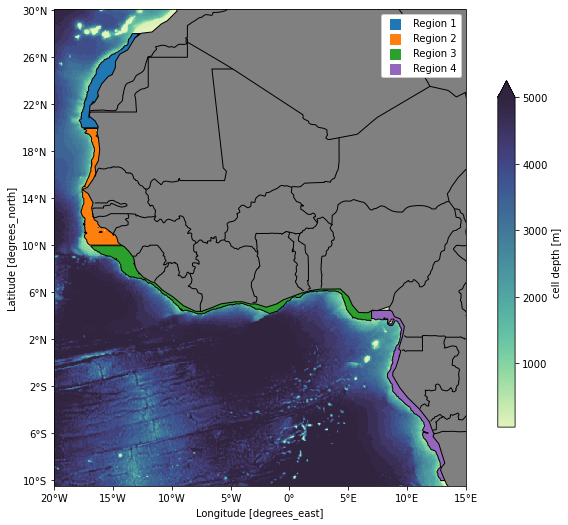

In [68]:
# plot all release zones
lat_b = (-11,31)#slice in 10! steps
lon_b = (-21,16)
land = cpf.NaturalEarthFeature('physical', 'land', \
    scale='110m', edgecolor='k', facecolor=cpf.COLORS['land'])

mask_list = [dm_1,dm_2,dm_3,dm_4]
region_list = ['Region 1','Region 2','Region 3','Region 4']


yt_ind = np.where((t_lat <= lat_b[1]) & (t_lat>= lat_b[0]))[0]  
xt_ind = np.where((t_lon <= lon_b[1]) & (t_lon >= lon_b[0]))[0]
mesh_t_lon, mesh_t_lat = np.meshgrid(t_lon[xt_ind],t_lat[yt_ind])


t = xr.open_dataset(data_path / t_file)
t_sel = t.vosaline[:,:,yt_ind,xt_ind].sel( # 5 oberste schichten
    time_counter = "2011-01-01") # 1 month december

depth_ind = t_sel.where(t_sel == 0).fillna(1).sum(dim = "deptht").astype('int')
depth_tgrid =  t_sel.deptht.isel(deptht = depth_ind)
del t

x_lines = np.arange(-20,20,5).tolist()
y_lines = np.arange(-10,32,4).tolist()

fig, ax1 = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(8, 9))

#bathymetry
pcol = ax1.pcolormesh(mesh_t_lon, mesh_t_lat,depth_tgrid.squeeze(), 
                      cmap = cmo.tools.crop_by_percent(cmo.cm.deep, 10, which='both', N=None), vmin = 35,vmax = 5000, rasterized = True)

#regions
for i,mask in enumerate(mask_list):
    plot_region(mask)

ax1.add_feature(land,facecolor='gray',zorder = 2, rasterized = True)
ax1.add_feature(cpf.BORDERS, zorder = 2, rasterized = True)
cbar = plt.colorbar(pcol,extend = 'max', pad = cb_pad, fraction = cb_fraction*0.8)
cbar.set_label('cell depth [m]')

ax1.set_xticks(x_lines, crs=proj)
ax1.set_yticks(y_lines, crs=proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("")
ax1.set_extent([-20, 15, -10.5, 29.])

ax1.legend(loc = 'upper right',framealpha = 1)
plt.tight_layout()
#plt.savefig('pics/map_shelf_zones_5kbathymetry.svg', format = 'svg', dpi = 700) 
#plt.savefig('pics/shelf_relesezone.png', dpi = 300, bbox_inches = 'tight')